In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
!pip install prophet
from prophet import Prophet

# Cargar el dataset
from google.colab import drive
drive.mount('/content/drive')

data = pd.read_csv("/content/drive/My Drive/MODELOS MONOGRAFIA/otrasinfeccionesMonografia.csv", sep=";")

# Mostrar las primeras filas del dataset para analizar su estructura
data.head()

Mounted at /content/drive


,fecha,semana,tipo,varones,mujeres,total
0,7/1/2019,1,EDA,486,527,1013
1,7/1/2019,1,IRAsinNeumo,1176,1292,2468
2,7/1/2019,1,neumonia,30,36,66
3,14/1/2019,2,EDA,585,627,1212
4,14/1/2019,2,IRAsinNeumo,1789,1963,3752


In [ ]:
# Filtrar los datos para Neumonía en mujeres y preparar el formato
data_ira_mujeres = data[data['tipo'] == 'IRAsinNeumo'][['fecha', 'mujeres']]
data_ira_mujeres['fecha'] = pd.to_datetime(data_ira_mujeres['fecha'], dayfirst=True)
data_ira_mujeres = data_ira_mujeres.sort_values(by='fecha')
data_ira_mujeres.set_index('fecha', inplace=True)

In [ ]:
# Preparar los datos en el formato requerido para Prophet
data_prophet = data_ira_mujeres.reset_index()
data_prophet.columns = ['ds', 'y']  # Renombrar columnas

# Dividir en entrenamiento y prueba (85% entrenamiento, 15% prueba)
train_size = int(len(data_prophet) * 0.85)
train_prophet = data_prophet[:train_size]
test_prophet = data_prophet[train_size:]

In [ ]:
# Configurar y entrenar el modelo Prophet
model_prophet = Prophet()
model_prophet.fit(train_prophet)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmph_wfr931/030fmfbi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph_wfr931/354de9x7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=310', 'data', 'file=/tmp/tmph_wfr931/030fmfbi.json', 'init=/tmp/tmph_wfr931/354de9x7.json', 'output', 'file=/tmp/tmph_wfr931/prophet_modelz4faplkz/prophet_model-20241130161045.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:10:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:10:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# Crear un DataFrame con las fechas del conjunto de prueba para realizar predicciones
future = model_prophet.make_future_dataframe(periods=len(test_prophet), freq='W')
forecast = model_prophet.predict(future)

# Extraer solo las predicciones correspondientes al conjunto de prueba
test_forecast = forecast[['ds', 'yhat']].iloc[-len(test_prophet):]

In [ ]:
# Calcular las métricas de evaluación
y_true = test_prophet['y'].values
y_pred = test_forecast['yhat'].values

mae_prophet = mean_absolute_error(y_true, y_pred)
rmse_prophet = np.sqrt(mean_squared_error(y_true, y_pred))
mape_prophet = mean_absolute_percentage_error(y_true, y_pred) * 100  # Convertir a porcentaje
smape_prophet = 100 * np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))

# Imprimir métricas de evaluación
print(f'MAE: {mae_prophet:.2f}')
print(f'RMSE: {rmse_prophet:.2f}')
print(f'MAPE: {mape_prophet:.2f}%')
print(f'sMAPE: {smape_prophet:.2f}%')

MAE: 724.01
RMSE: 860.13
MAPE: 31.64%
sMAPE: 25.31%


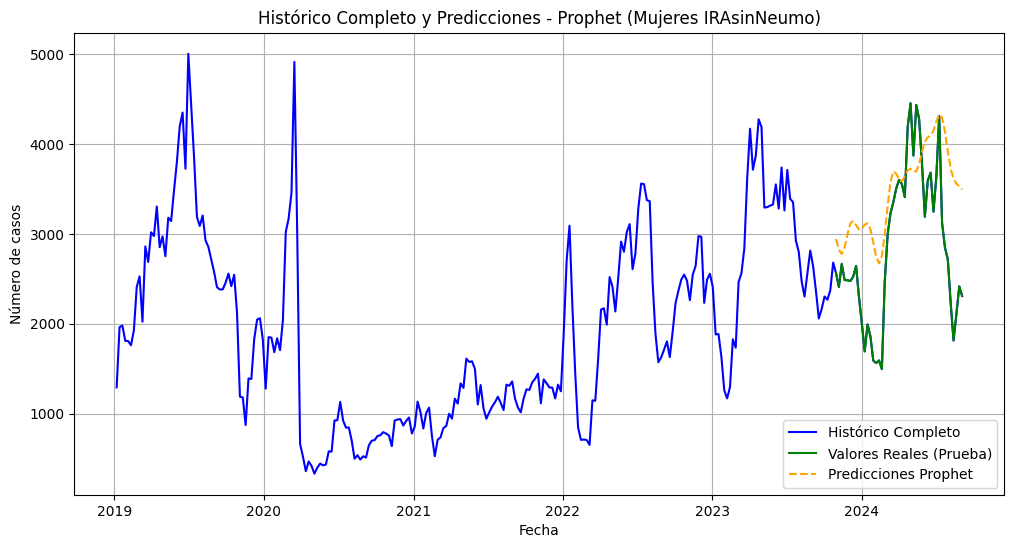

In [ ]:
# Graficar el histórico y las predicciones del modelo Prophet
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(data_ira_mujeres.index, data_ira_mujeres['mujeres'], label="Histórico Completo", color="blue")
plt.plot(test_prophet['ds'], y_true, label="Valores Reales (Prueba)", color="green")
plt.plot(test_prophet['ds'], y_pred, color='orange', linestyle='--', label="Predicciones Prophet")
plt.title("Histórico Completo y Predicciones - Prophet (Mujeres IRAsinNeumo)")
plt.xlabel("Fecha")
plt.ylabel("Número de casos")
plt.legend()
plt.grid(True)
plt.show()